<a href="https://colab.research.google.com/github/SNMS95/ADTO/blob/main/TO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === User-defined Settings for Topology Optimization ===

ML_framework_to_use = "torch"  # Choose ML backend: "torch" or "jax"

# Grid resolution (number of finite elements in x and y directions)
# ⚠️ CNN only supports multiples of 8 for Nx and Ny
Nx = 96                       # Number of elements along x-axis
Ny = 64                       # Number of elements along y-axis

# Material properties
E0 = 1.0                     # Young's modulus of solid material
Emin = 1e-9                  # Young's modulus of void
nu = 0.3                     # Poisson's ratio

# Filter and penalization
rmin = 2.0                   # Radius for density filter
penal = 3.0                  # SIMP penalization factor

# Optimization control
max_iterations = 100         # Number of optimization steps
volfrac = 0.4

# # Sanity checks
# assert ML_framework_to_use in ["jax", "torch"]
assert penal >= 1
assert rmin >= 1

In [ ]:
# Check if in Colab and setup accordingly
try:
    import google.colab
    # We're in Colab - clone and setup
    import os
    if not os.path.exists('ADTO'):
        !git clone https://github.com/SNMS95/ADTO.git
    %cd ADTO
    print("🔧 Colab setup complete")
except:
    # We're running locally - no setup needed
    print("🔧 Running locally")

# Set backend before importing anything else
import os
os.environ["ML_BACKEND"] = ML_framework_to_use
from common_numpy import setup_fea_problem, optimality_criteria
from backend_utils import (compute_compliance_differentiable,
                           apply_density_filter)

🔧 Running locally
Using backend: jax


In [ ]:
def run_with_jax_backend(problem_data, rho_init=None, max_iterations=100):
    """Training example with JAX backend"""
    import jax
    import jax.numpy as jnp
    print("Training with JAX backend...")

    # Initialize design variables
    if rho_init is None:
        rho_init = jnp.ones((problem_data['Ny'], problem_data['Nx'])) * volfrac  # Initial guess
    else:
        assert rho_init.shape == (problem_data['Ny'], problem_data['Nx'])
    # Create loss function and optimizer

    def volume_constraint_fn(rho):
        output = rho.ravel(order='F')
        # Apply filter
        physical_densities = apply_density_filter(output, problem_data)
        constraint = jnp.mean(physical_densities) - volfrac
        return constraint

    def obj_and_constraint_fn(rho):
        output = rho.ravel(order='F')
        # Apply filter
        physical_densities = apply_density_filter(output, problem_data)
        # Compute compliance
        compliance, ce = compute_compliance_differentiable(physical_densities, problem_data)
        constraint = volume_constraint_fn(rho)
        aux_info= (compliance, constraint, physical_densities)
        return (compliance, constraint), aux_info

    # Training loop
    objs = []
    constraints = []
    designs = []

    rho = rho_init

    for itr in range(max_iterations):
        jacobian, aux = jax.jacrev(
            obj_and_constraint_fn, has_aux=True)(rho)
        obj_grads = jacobian[0]
        constraint_grads = jacobian[1]
        rho = optimality_criteria(
            rho.ravel(), obj_grads.ravel(), constraint_grads.ravel(),
            vol_constr_fn=volume_constraint_fn)
        obj, constr, design = aux
        objs.append(obj)
        constraints.append(constr)
        designs.append(design)
        if itr % 1 == 0:
            print(f"JAX - Iteration {itr}, Obj: {obj:.6f}, constr: {constr:.6f}")

    return objs, constraints, designs


def run_with_torch_backend(problem_data, rho_init=None, max_iterations=100):
    """Training example with PyTorch backend"""
    import torch
    print("Training with PyTorch backend...")

    # Initialize design variables
    if rho_init is None:
        rho_init = torch.ones((problem_data['Ny'], problem_data['Nx'])) * volfrac  # Initial guess
    else:
        assert rho_init.shape == (problem_data['Ny'], problem_data['Nx'])
    rho = rho_init.clone().requires_grad_(True)

    def volume_constraint_fn(rho):
        output = rho.t().reshape(-1)  # equivalent to Fortran order flatten
        # Apply filter
        physical_densities = apply_density_filter(output, problem_data)
        constraint = torch.mean(physical_densities) - volfrac
        return constraint

    def obj_and_constraint_fn(rho):
        output = rho.t().reshape(-1)  # equivalent to Fortran order flatten
        # Apply filter
        physical_densities = apply_density_filter(output, problem_data)
        # Compute compliance
        compliance, ce = compute_compliance_differentiable(physical_densities, problem_data)
        constraint = volume_constraint_fn(rho)
        aux_info= (compliance.item(), constraint.item(), physical_densities.detach().cpu().numpy())
        return compliance, constraint, aux_info

    # Training loop
    objs = []
    constraints = []
    designs = []

    for itr in range(max_iterations):
        obj, constr, aux = obj_and_constraint_fn(rho)

        # Compute gradients
        obj_grads = torch.autograd.grad(obj, rho, retain_graph=True)[0]
        constraint_grads = torch.autograd.grad(constr, rho)[0]

        # Convert to numpy (Fortran ordering)
        rho_np = optimality_criteria(
            rho.detach().cpu().numpy().T.ravel(),
            obj_grads.detach().cpu().numpy().T.ravel(),
            constraint_grads.detach().cpu().numpy().T.ravel(),
            vol_constr_fn=volume_constraint_fn,
        )

        # Update rho (new leaf tensor)
        rho = torch.from_numpy(rho_np.reshape(problem_data['Ny'], problem_data['Nx'],
                                               order='F')).float().requires_grad_(True)

        obj_np, constr_np, design = aux
        objs.append(obj_np)
        constraints.append(constr_np)
        designs.append(design)

        if itr % 1 == 0:
            print(f"PyTorch - Iteration {itr}, Obj: {obj_np:.6f}, constr: {constr_np:.6f}")

    return objs, constraints, designs


    
def run_optimization(problem_data):
    """Train the neural network model."""
    backend = ML_framework_to_use
    if backend == "jax":
        return run_with_jax_backend(problem_data)
    elif backend == "pytorch":
        return run_with_torch_backend(problem_data)
    else:
        raise ValueError(f"Unknown backend: {backend}")

In [9]:
problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                        nu=nu)
objs, const, designs = run_optimization(problem_data)

Training with JAX backend...
JAX - Iteration 0, Obj: 498.232813, constr: 0.000000
JAX - Iteration 1, Obj: 424.039873, constr: 0.000881
JAX - Iteration 2, Obj: 266.908183, constr: 0.000103
JAX - Iteration 3, Obj: 196.023351, constr: -0.000057
JAX - Iteration 4, Obj: 157.712985, constr: -0.000312
JAX - Iteration 5, Obj: 132.402162, constr: 0.000449
JAX - Iteration 6, Obj: 117.461216, constr: -0.000723
JAX - Iteration 7, Obj: 104.920230, constr: 0.000634
JAX - Iteration 8, Obj: 95.101498, constr: -0.000734
JAX - Iteration 9, Obj: 87.025193, constr: -0.000310
JAX - Iteration 10, Obj: 81.246003, constr: 0.000905
JAX - Iteration 11, Obj: 77.097560, constr: 0.000952
JAX - Iteration 12, Obj: 73.533553, constr: -0.000471
JAX - Iteration 13, Obj: 70.019619, constr: 0.000570
JAX - Iteration 14, Obj: 67.738239, constr: -0.000294
JAX - Iteration 15, Obj: 66.148195, constr: 0.000292
JAX - Iteration 16, Obj: 65.256978, constr: 0.000300
JAX - Iteration 17, Obj: 64.692741, constr: -0.000283
JAX - Itera

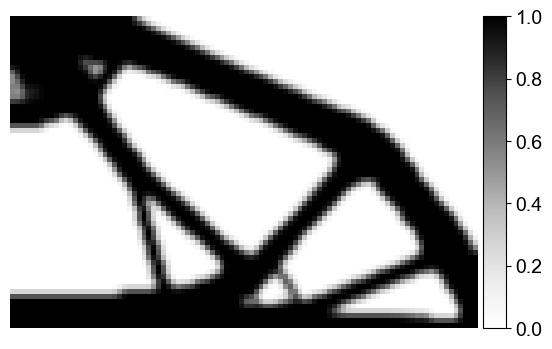

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()

# Plot design
im = ax.imshow(design.reshape(Ny, Nx, order='F'), cmap="Greys")
ax.axis("off")

# Attach colorbar axis with same height
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # narrow, right-side
cbar = fig.colorbar(im, cax=cax)

# Formatting
cbar.ax.tick_params(labelsize=14)
plt.rcParams.update({"font.sans-serif": "Arial", "font.family": "sans-serif"})

# Save as PDF
fig.savefig("design.pdf", bbox_inches="tight", dpi=300)

plt.show()

In [ ]:

def run_with_pytorch_backend():
    """Training example with PyTorch backend"""
    import torch
    print("Training with PyTorch backend...")

    # Setup problem
    problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                           nu=nu)
    # Create nn model
    model, model_input = create_network_and_input(nn_type=nn_type, hyper_params=nn_arch_details,
                                   random_seed=random_seed, grid_size=(Ny, Nx))

    # Setup optimizer
    optimizer = get_optimizer(optimizer_str, **optimizer_hyper_params)

    # Training loop
    for epoch in range(max_iterations):
        with torch.enable_grad():
            # Forward pass
            densities = model(model_input)
            densities = volume_enforcing_filter(densities, volfrac)
            filtered_densities = apply_density_filter(densities, problem_data)

            # Physics simulation
            compliance, _ = compute_compliance_differentiable(filtered_densities.flatten(), problem_data)
            # Backward pass
            model.zero_grad()
            trainable_weights = [v for v in model.trainable_weights]

            # Call torch.Tensor.backward() on the loss to compute gradients
            # for the weights.
            compliance.backward()
            gradients = [v.value.grad for v in trainable_weights]

            # Update weights
            with torch.no_grad():
                optimizer.apply(gradients, trainable_weights)

        if epoch % 10 == 0:
            print(f"PyTorch - Epoch {epoch}, Loss: {compliance.item():.6f}")

    return compliance.item()

def train_nn_model():
    """Train the neural network model."""
    backend = keras.backend.backend()
    if backend == "jax":
        return train_with_jax_backend()
    elif backend == "pytorch":
        return train_with_pytorch_backend()
    else:
        raise ValueError(f"Unknown backend: {backend}")

AD_in_TO.ipynb	fea_bisec_numpy.py  LICENSE	 README.md
custom_vjps.py	jax		    __pycache__
